In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
import seaborn as sns
import healpy as hp

from importlib import reload

import sys, os
sys.path.append('/home/apizzuto/Nova/scripts/')
import plotting

import histlite as hl
import csky as cy

from glob import glob
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')

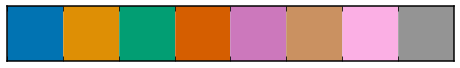

In [3]:
palette = sns.color_palette("colorblind", 8)
sns.palplot(palette)

In [4]:
ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/')
ana = cy.get_analysis(cy.selections.repo,
    'version-002-p10', # 'version-003-p02'
    cy.selections.GRECOOnlineDataSpecs.GRECO_IC86_2012_2019,
    dir=ana_dir)

Setting up Analysis for:
GRECO_IC86_2012_2019
Setting up GRECO_IC86_2012_2019...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2012.nue_merged.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2012.numu_merged.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2012.nutau_merged.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2012.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2013.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2014.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2015.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2016.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2017.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2018.data.npy ...
Reading /data/ana/analyses/greco_online/version-002-p10/IC86_2019.data.npy ...
Reading /data/ana/analyses/gr

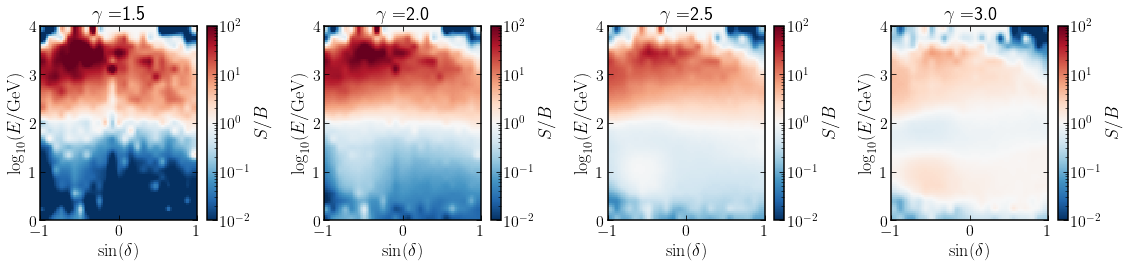

In [5]:
gammas = [1.5, 2.0, 2.5, 3.0]

fig, axs = plt.subplots(1, 4, figsize=(16,4))
axs = np.ravel(axs)
for (i, gamma) in enumerate(gammas):
    ax = axs[i]
    eprm = ana[0].energy_pdf_ratio_model
    ss = dict(zip(eprm.gammas, eprm.ss_hl))
    things = hl.plot2d(ax, ss[gamma].eval(bins=100),
                       vmin=1e-2, vmax=1e2, log=True, cbar=True, cmap='RdBu_r')
    ax.set_title(r'$\gamma = $' + f'{gamma:.1f}')
    things['colorbar'].set_label(r'$S/B$')
    ax.set_xlabel(r'$\sin(\delta)$')
    ax.set_ylabel(r'$\log_{10}(E/\mathrm{GeV})$')
plt.tight_layout()
# axs[-1].set_visible(False)

In [23]:
gamma_novae = plotting.StackingPlots(
    86400., 'gamma', 'gamma', seed=2, index=[2.0, 2.5, 3.0]
    )
all_novae = plotting.StackingPlots(
    86400., 'all_novae', 'optical', seed=2, index=[2.0, 2.5, 3.0]
    )
gamma_novae.get_all_sens()
all_novae.get_all_sens()

In [11]:
from scipy import stats

In [21]:
chi2cdf(0)

0.0

In [139]:
def make_efficiency_curve(stack, discovery=False):
    fig, ax = plt.subplots()
    
    gam_cols = {2.0: 'C0', 2.5: 'C1', 3.0: 'C3'}
    
    for gamma in [2.0, 2.5, 3.0]:
        if discovery:
            res = stack.discovery[gamma]['info']
            sens = stack.discovery[gamma]['n_sig']
            e2dnde = stack.discovery[gamma]['E2dNdE']
            beta = res['ts_beta']
        else:
            res = stack.sensitivity[gamma]['info']
            sens = stack.sensitivity[gamma]['n_sig']
            e2dnde = stack.sensitivity[gamma]['E2dNdE']
            beta = res['ts_beta']

        my_lab = r'$\gamma = {<gam>}$'.replace('<gam>', f'{gamma:.1f}')
        my_lab += f', sens.= {sens:.1f} events'
        plt.errorbar(
            res['n_sigs'],
            res['CLs'],
            yerr=res['sigmas'], linestyle='',
            color=gam_cols[gamma],
            capsize=4, marker='o', markersize=4,
            label=my_lab)

        dof = res['dof']
        loc = res['loc']
        scale = res['scale']
        params = dof, loc, scale
        chi2cdf = lambda n: stats.chi2.cdf(n, *params)

        xs = np.linspace(0., max(res['n_sigs']), 500)
        ys = chi2cdf(xs)
        plt.plot(xs, ys, color=gam_cols[gamma])

        plt.axvline(sens, ls='dashed', lw=1.25, color=gam_cols[gamma])
        
    plt.axhline(beta, ls='dashed', lw=1, color='grey')
    
    plt.xlabel(r'$\langle n_{\mathrm{inj}} \rangle$')
    if discovery:
        nsigma = stack.discovery_nsigma
        thresh = r'$q_{<nsigma>\sigma}(TS_{\mathrm{bg}})$'.replace('<nsigma>', f'{nsigma:.0f}')
    else:
        thresh = r'$q_{50}(TS_{\mathrm{bg}})$'
    plt.ylabel(r'$P(TS_{\mathrm{sig}}) >$' + thresh)
    
    plt.legend(loc=4, framealpha=0.9)
        
    plt.show()

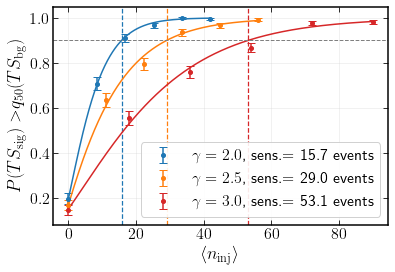

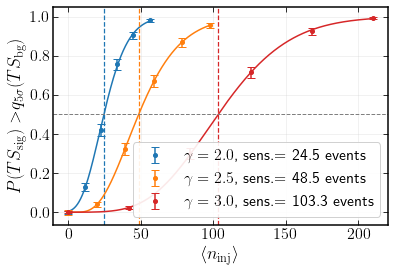

In [140]:
make_efficiency_curve(gamma_novae, discovery=False)
make_efficiency_curve(gamma_novae, discovery=True)

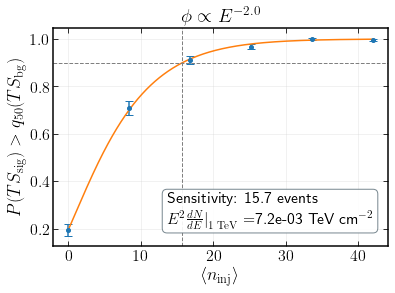

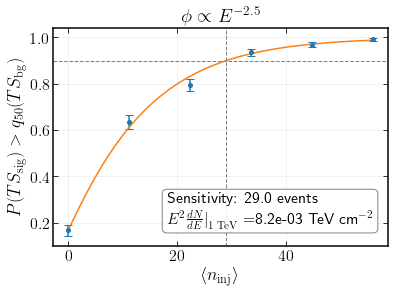

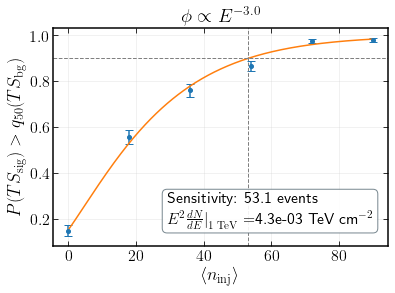

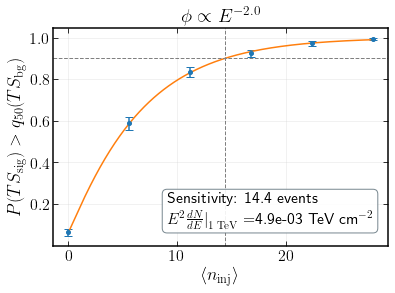

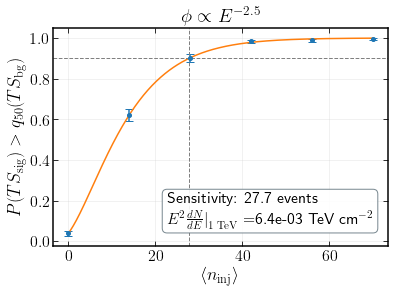

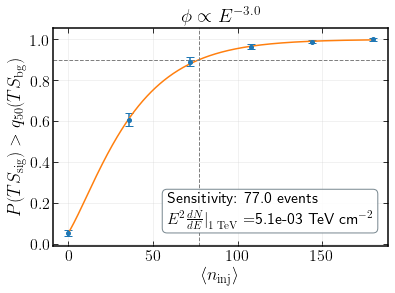

In [105]:
for gamma in [2.0, 2.5, 3.0]:
    make_efficiency_curve(gamma_novae, gamma)
    
for gamma in [2.0, 2.5, 3.0]:
    make_efficiency_curve(all_novae, gamma)

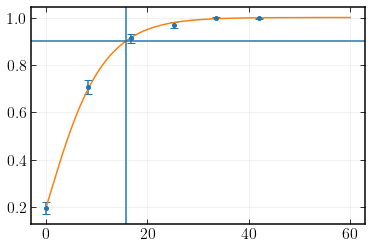

In [24]:
res = gamma_novae.sensitivity[2.0]['info']
plt.errorbar(
    res['n_sigs'],
    res['CLs'],
    yerr=res['sigmas'], linestyle='', capsize=4, marker='o', markersize=4)

dof = res['dof']
loc = res['loc']
scale = res['scale']
params = dof, loc, scale
chi2cdf = lambda n: stats.chi2.cdf(n, *params)

xs = np.linspace(0., 60., 500)
ys = chi2cdf(xs)
plt.plot(xs, ys)

plt.axvline(gamma_novae.sensitivity[2.0]['n_sig'])
plt.axhline(0.9)

plt.show()

In [7]:
gamma_novae.sensitivity

{2.0: {'n_sig': 24.387496314307256,
  'n_sig_error': 0.0,
  'n_sig_history': array([24.38749631]),
  'n_sig_error_history': array([0.]),
  'n_trials_history': [100],
  'info': {'n_sig': 24.387496314307256,
   'n_sig_chi2cdf': 24.387496314307256,
   'n_sig_spline': 24.000000000000064,
   'dof': 0.9501807896830099,
   'loc': 8.497194879800594,
   'scale': 6.1169790976556,
   'params': array([0.95018079, 8.49719488, 6.1169791 ]),
   'spline': <scipy.interpolate._cubic.PchipInterpolator at 0x7fdf71fb8170>,
   'n_sigs': array([ 0., 12., 24., 36., 48., 60.]),
   'CLs': array([0.  , 0.57, 0.9 , 0.96, 1.  , 1.  ]),
   'sigmas': array([0.01959592, 0.04950758, 0.03      , 0.01959592, 0.01959592,
          0.01959592]),
   'ts_threshold': 0.0,
   'ts_from_fit': True,
   'ts_nsigma': 0,
   'ts_beta': 0.9},
  'tss': {0.0: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 

In [6]:
gamma_novae.all_results

{2.0: {2732.2078983854794: {'bg': Chi2TSD(50000 trials, eta=0.573, ndof=1.052, median=0.032 (from fit 0.032)),
   'sensitivity': {'n_sig': 5.023189074196912,
    'n_sig_error': 0.0,
    'n_sig_history': array([5.02318907]),
    'n_sig_error_history': array([0.]),
    'n_trials_history': [250],
    'info': {'n_sig': 5.023189074196912,
     'n_sig_chi2cdf': inf,
     'n_sig_spline': 5.023189074196912,
     'dof': 42.24191297969519,
     'loc': -28.37865237453435,
     'scale': 0.005469359227781134,
     'params': array([ 4.22419130e+01, -2.83786524e+01,  5.46935923e-03]),
     'spline': <scipy.interpolate._cubic.PchipInterpolator at 0x7fdf71f9c7d0>,
     'n_sigs': array([ 0. ,  2.8,  5.6,  8.4, 11.2, 14. ]),
     'CLs': array([0.5  , 0.816, 0.916, 0.98 , 0.98 , 1.   ]),
     'sigmas': array([0.03162278, 0.02450665, 0.01754355, 0.00885438, 0.00885438,
            0.00885438]),
     'ts_threshold': 0.031896728442168176,
     'ts_from_fit': True,
     'ts_nsigma': 0,
     'ts_beta': 0.9},
 

Setting up Analysis for:
GRECO_IC86_2012_2019
Setting up GRECO_IC86_2012_2019...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
          gamma
     4.0000e+00
Done.
19.316392733656656 33.41772151898734 1.949367088607595
Setting up Analysis for:
GRECO_IC86_2012_2019
Setting up GRECO_IC86_2012_2019...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
          gamma
     4.0000e+00
Done.
31.78241245163983 75.9493670886076 2.1772151898734178


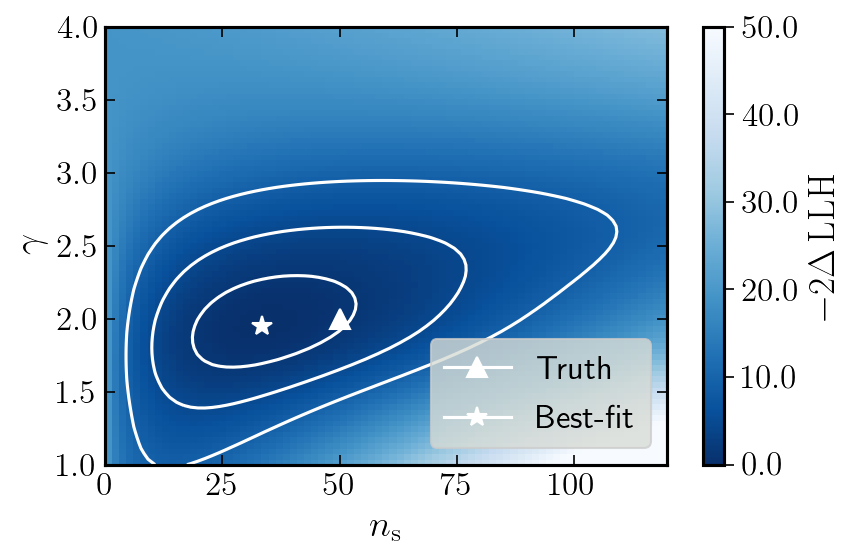

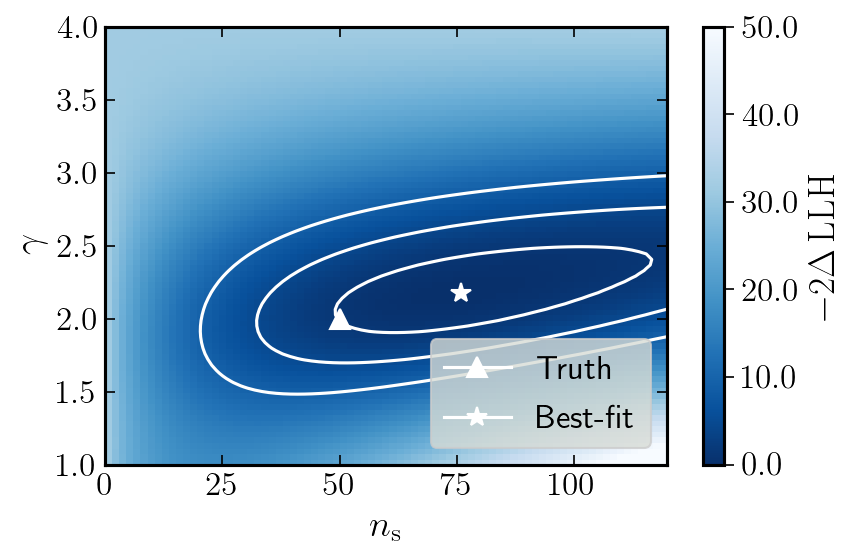

In [25]:
# TRY COLOR SCALE RdGy
gamma_novae.set_seed(2)
gamma_novae.likelihood_scan(n_inj=50.)

all_novae.set_seed(2)
all_novae.likelihood_scan(n_inj=50.)

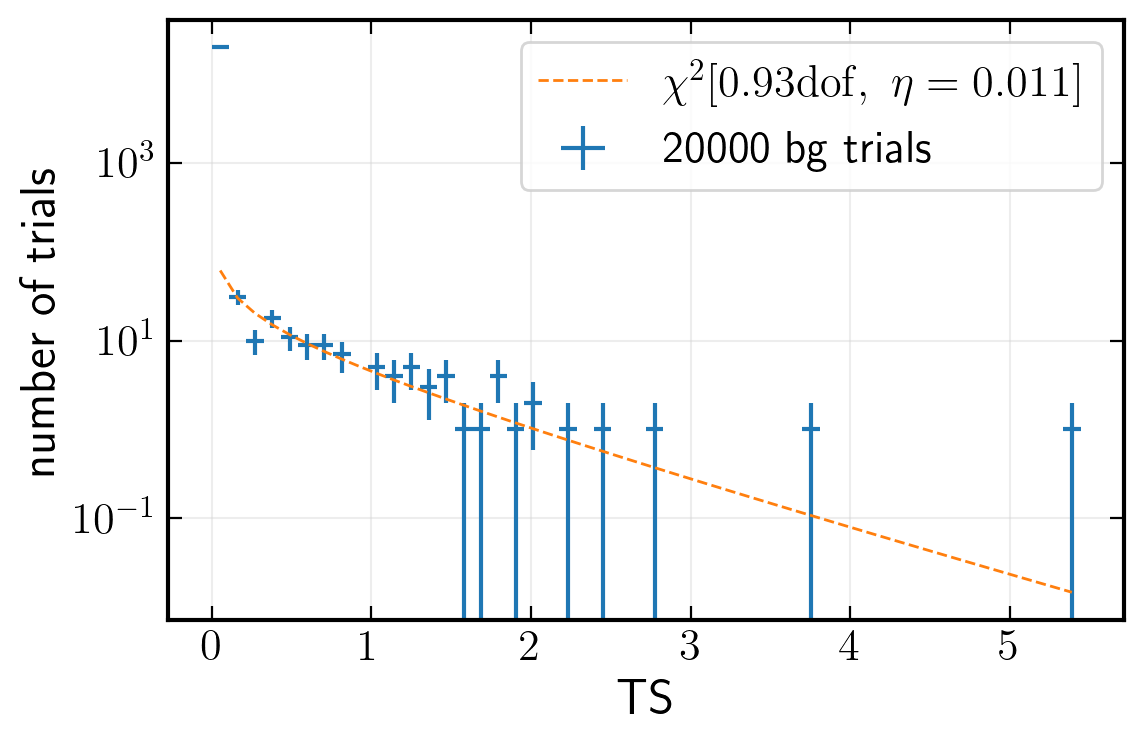

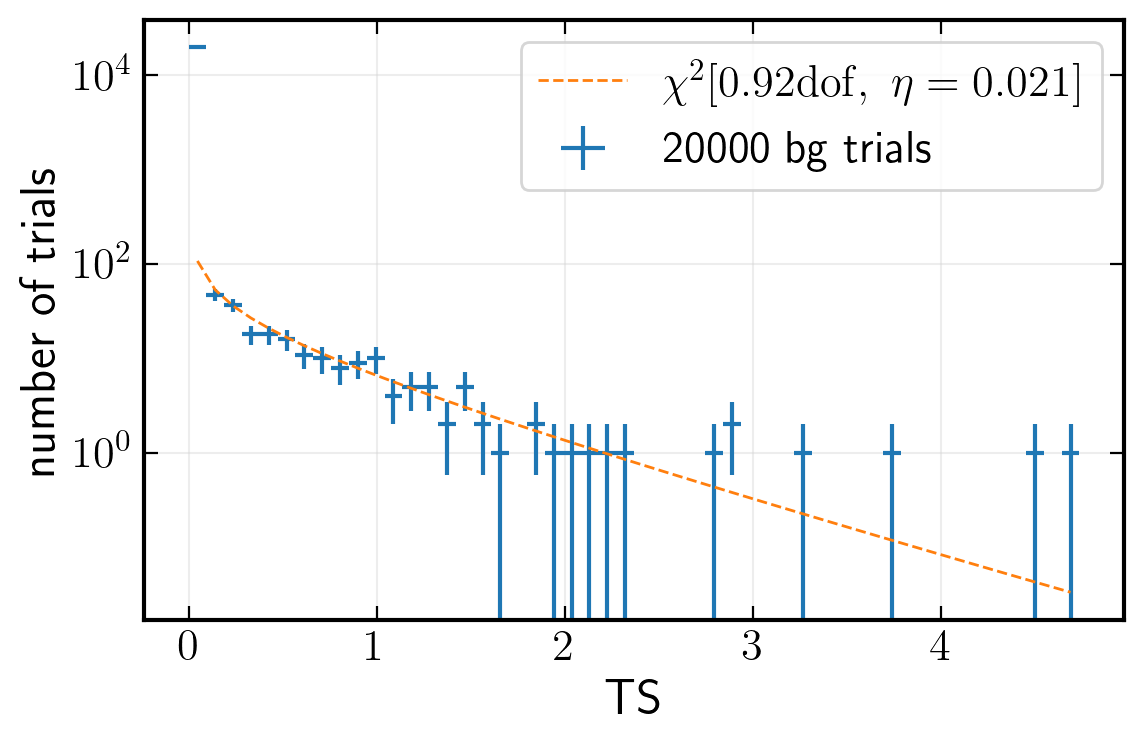

In [26]:
all_novae.background_distribution()
gamma_novae.background_distribution()

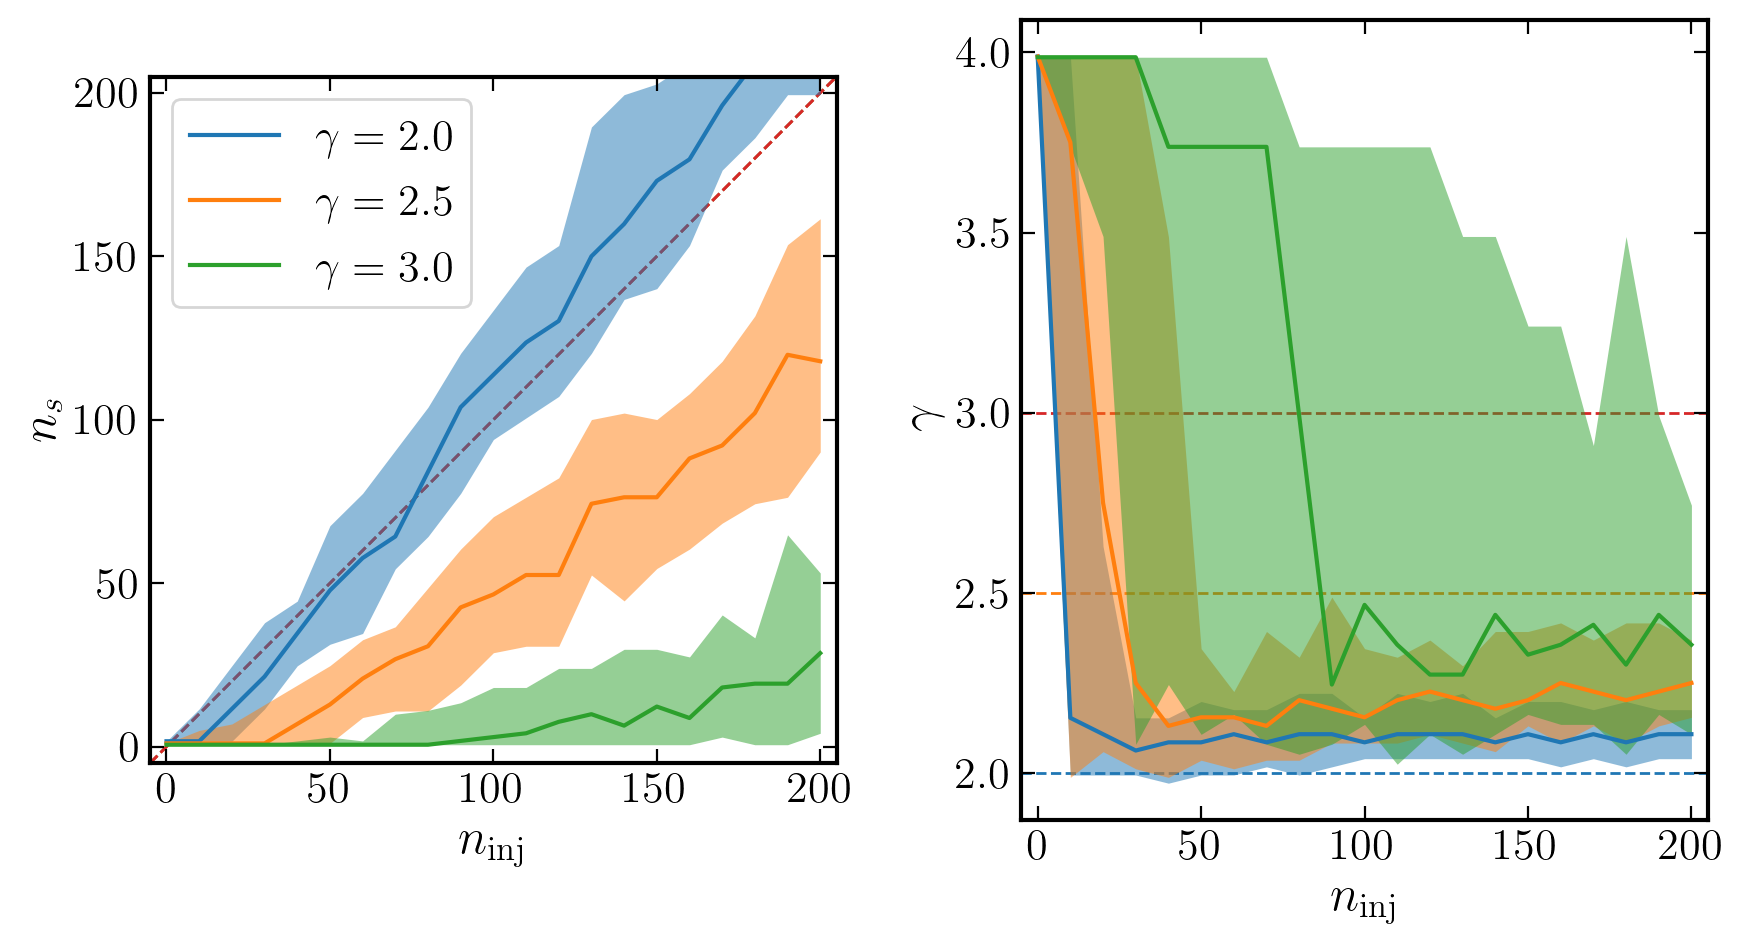

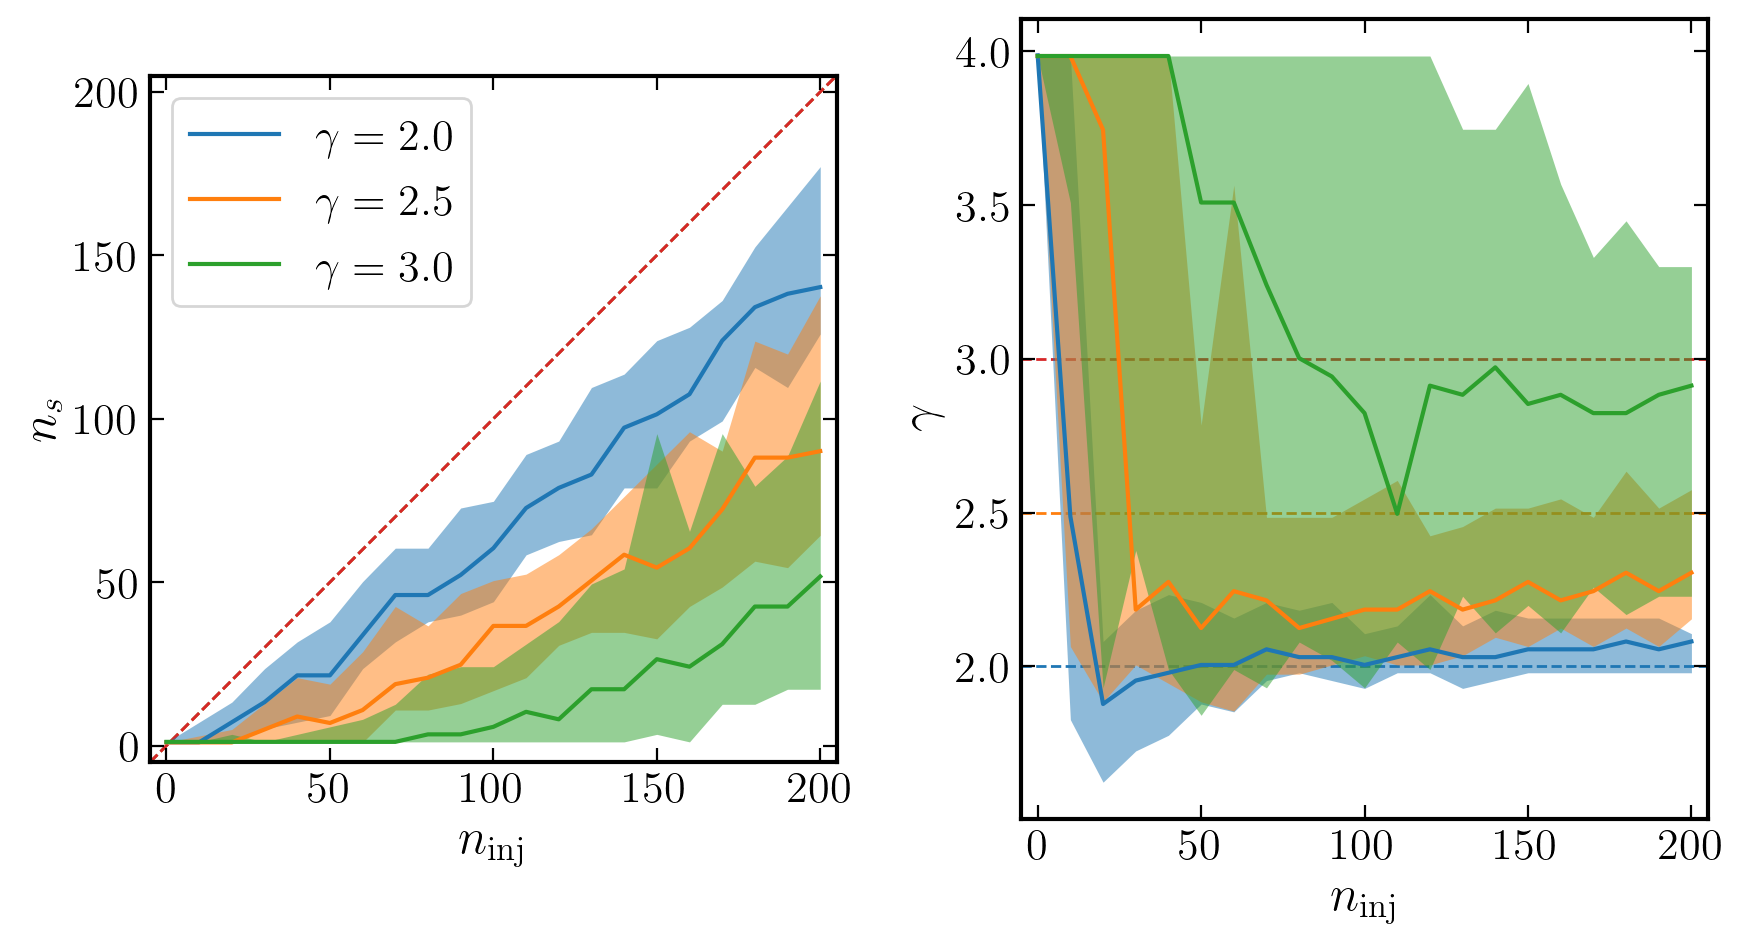

In [27]:
all_novae.fitting_plot(gamma=[2.0, 2.5, 3.0])
gamma_novae.fitting_plot(gamma=[2.0, 2.5, 3.0])

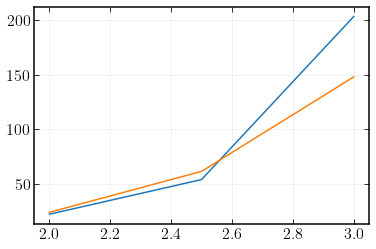

In [28]:
gams = np.asarray([2.0, 2.5, 3.0])
all_nsig_sens = [all_novae.sensitivity[gam]['n_sig'] for gam in gams]
gamma_nsig_sens = [gamma_novae.sensitivity[gam]['n_sig'] for gam in gams]
plt.plot(gams, all_nsig_sens)
plt.plot(gams, gamma_nsig_sens)

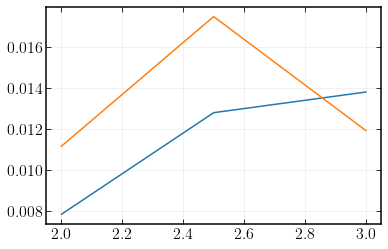

In [29]:
gams = np.asarray([2.0, 2.5, 3.0])
all_sens = [all_novae.sensitivity[gam]['E2dNdE'] for gam in gams]
gamma_sens = [gamma_novae.sensitivity[gam]['E2dNdE'] for gam in gams]
plt.plot(gams, all_sens)
plt.plot(gams, gamma_sens)

In [ ]:
r"$E^2 \frac{dN}{dE} @ 1$ TeV (TeV cm$^{-2}$)"

In [17]:
all_novae.sensitivity[2.0]['n_sig']

14.412739017918337

In [34]:
?stack_plots.plot_sensitivity_vs_time

In [39]:
stack_plots.all_results

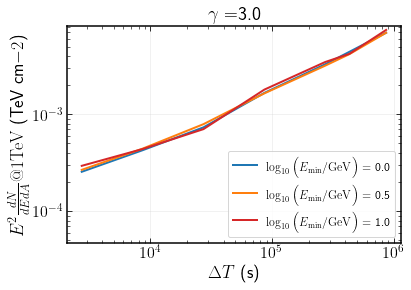

In [47]:
fig, ax = plt.subplots()
for minloge in [0.0, 0.5, 1.0]:
    stack_plots = plotting.StackingPlots(
        86400., 'gamma', 'gamma', seed=2, min_log_e=minloge, 
        allflavor=True, index=[2.0, 2.5, 3.0])
    stack_plots.plot_sensitivity_vs_time(gamma=3.0, ax=ax)

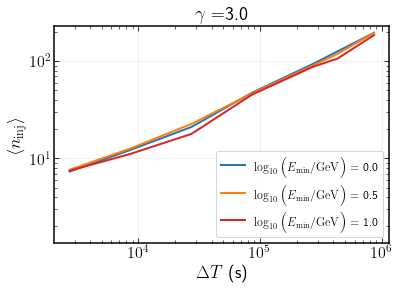

In [48]:
fig, ax = plt.subplots()
for minloge in [0.0, 0.5, 1.0]:
    stack_plots = plotting.StackingPlots(
        86400., 'gamma', 'gamma', seed=2, min_log_e=minloge, 
        allflavor=True, index=[2.0, 2.5, 3.0])
    stack_plots.plot_sensitivity_vs_time(gamma=3.0, ax=ax, in_flux=False)

Setting up Analysis for:
GRECO_IC86_2012_2019
Setting up GRECO_IC86_2012_2019...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
          gamma
     4.0000e+00
Done.
16.4620184906408 39.493670886075954 2.2531645569620253


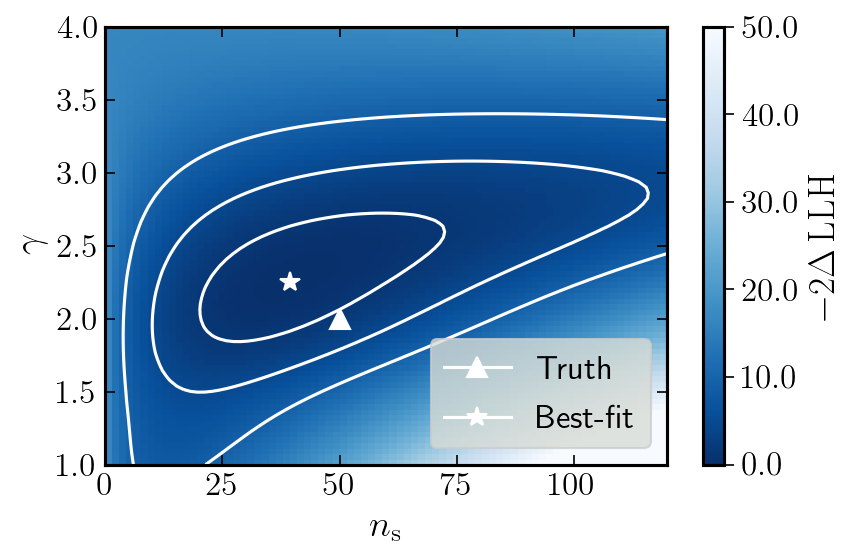

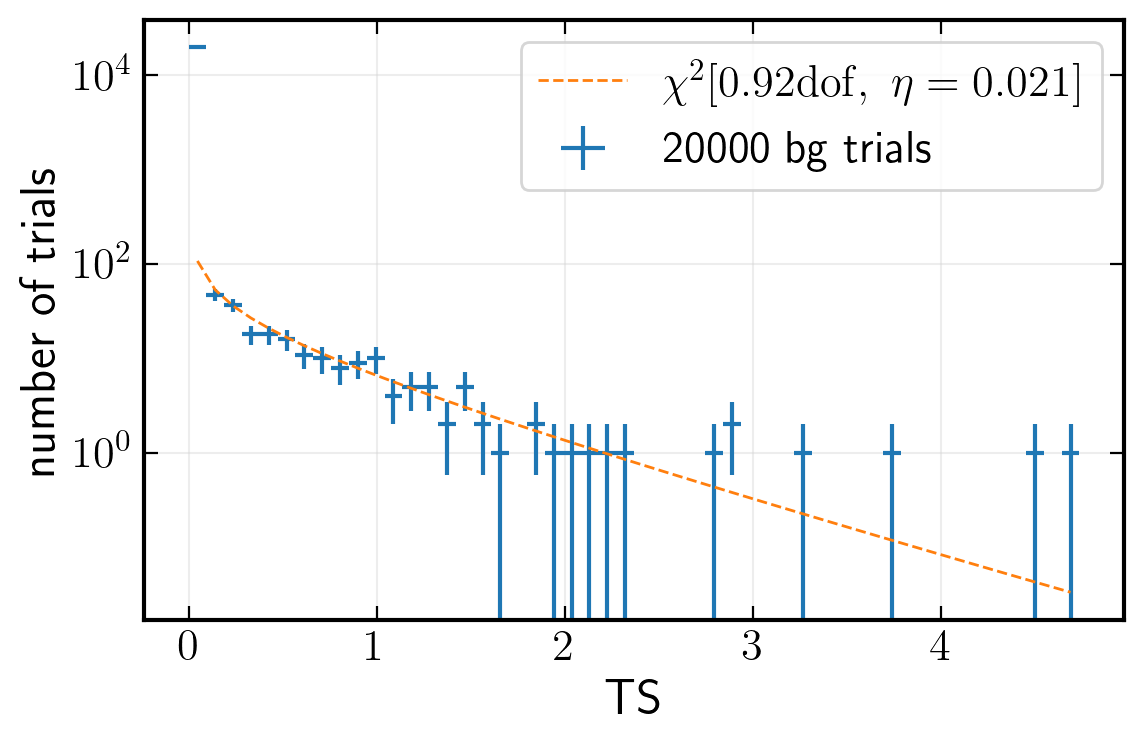

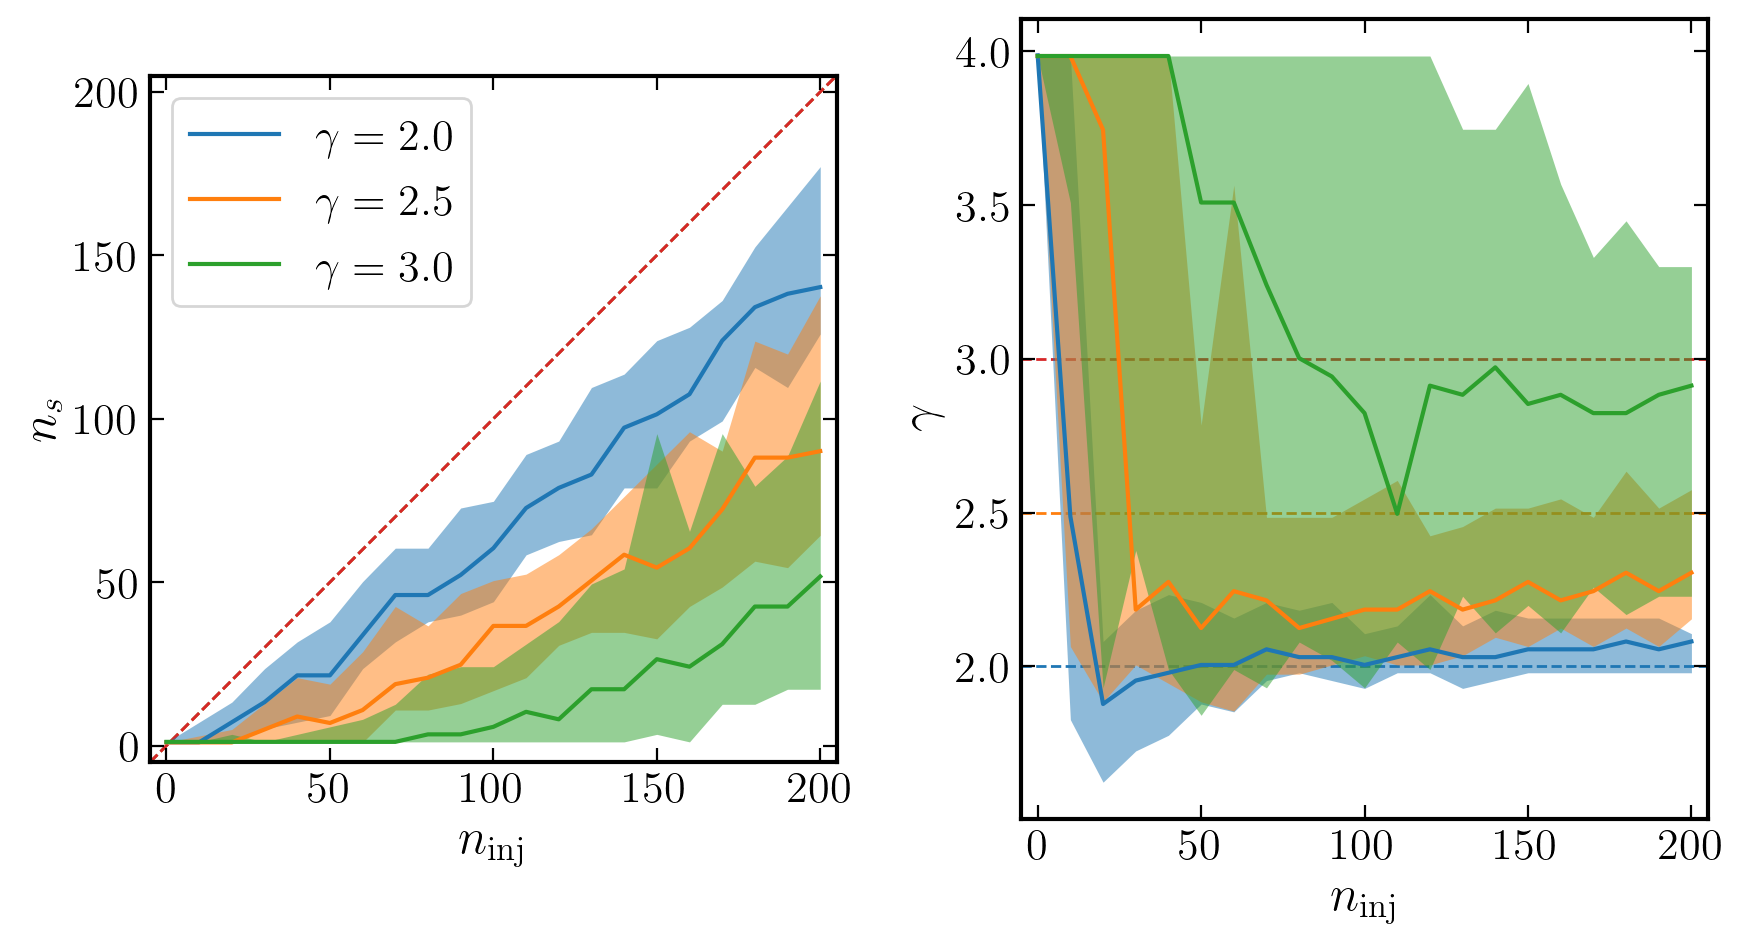

In [15]:
long_gamma_novae = plotting.StackingPlots(
    86400.*5., 'gamma', 'gamma', seed=2, index=[2.0, 2.5, 3.0]
    )
long_gamma_novae.get_all_sens()

long_gamma_novae.set_seed(1)
long_gamma_novae.likelihood_scan(n_inj=50.)

long_gamma_novae.background_distribution()

long_gamma_novae.fitting_plot(gamma=[2.0, 2.5, 3.0])

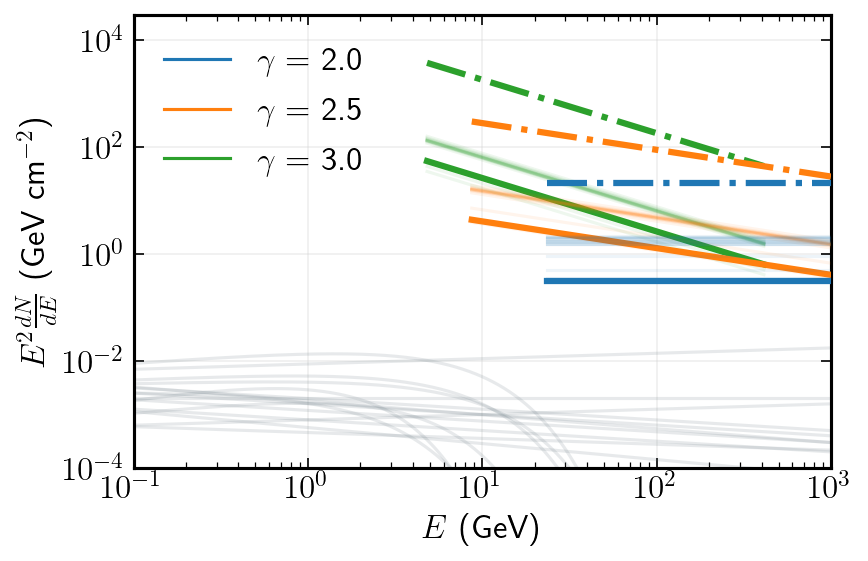

In [11]:
stack_plots = plotting.StackingPlots(86400., seed=2, min_log_e=None, index=[2.0, 2.5, 3.0])
stack_plots.get_all_sens()

cat = plotting.GammaCatalog(verbose = True)
cat.compare_photon_to_nus(delta_t = 86400., omit_title=True, alpha=0.08)

ens = np.logspace(-1., 3., 500)
gam_cols = {2.0: 'C0', 2.5: 'C1', 3.0: 'C2'}

for gamma in [2.0, 2.5, 3.0]:
    sens = stack_plots.sensitivity[gamma]['E2dNdE']
    central_90_energies = cat.central_90[gamma]
        
    nu_sens_spec = np.power(ens, -gamma)*sens*1e3*(1e-3)**(2.-gamma)
    en_msk = (ens > central_90_energies[0]) & (ens < central_90_energies[1])
    plt.plot(ens[en_msk], nu_sens_spec[en_msk]*ens[en_msk]**2,
           color=gam_cols[gamma], lw = 3.0, zorder=5*(5.-gamma), ls='-.')
    plt.plot(ens[en_msk], nu_sens_spec[en_msk]*ens[en_msk]**2/float(len(stack_plots.names)),
           color=gam_cols[gamma], lw = 3.0, zorder=5*(5.-gamma), ls='-')

In [25]:
stack_plots.sensitivity[2.0].keys()

AttributeError: 'StackingPlots' object has no attribute 'sensitivity'

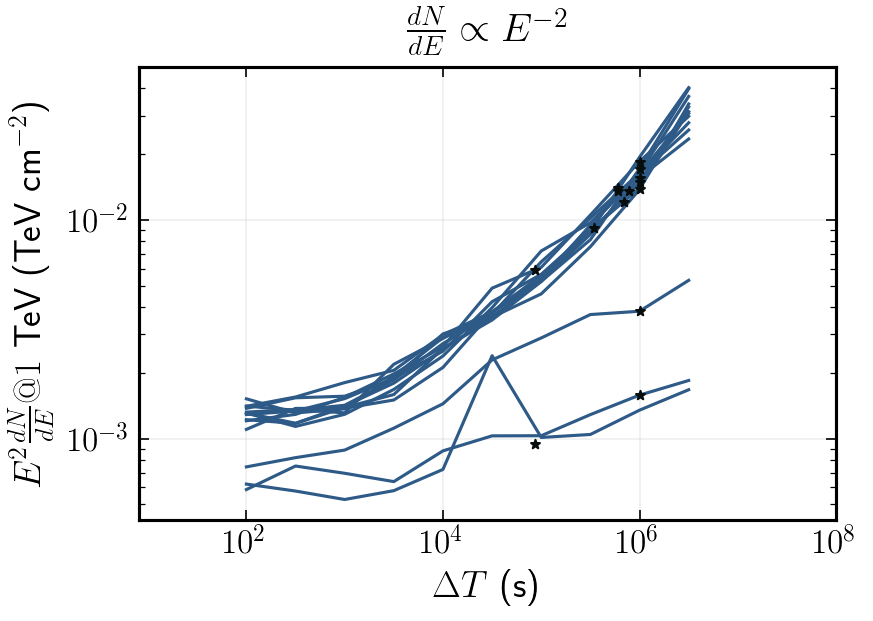

In [40]:
cat.sensitivity_vs_time()

In [15]:
plt.errorbar(results[2.0][0]['info']['n_sigs'], results[2.0][0]['info']['CLs'], yerr= results[2.0][0]['info']['sigmas'])

NameError: name 'results' is not defined

In [18]:
results[2.0][0]

{'n_sig': 7.716186578607563,
 'n_sig_error': 0.0,
 'n_sig_history': array([7.71618658]),
 'n_sig_error_history': array([0.]),
 'n_trials_history': [250],
 'info': {'n_sig': 7.716186578607563,
  'n_sig_chi2cdf': inf,
  'n_sig_spline': 7.716186578607563,
  'dof': 10,
  'loc': 0,
  'scale': 1.00000000002,
  'params': [10, 0, 1.00000000002],
  'spline': <scipy.interpolate._cubic.PchipInterpolator at 0x7f8f9571e170>,
  'n_sigs': array([ 0.,  6., 12., 18., 24., 30.]),
  'CLs': array([0.52 , 0.848, 0.98 , 0.996, 1.   , 1.   ]),
  'sigmas': array([0.03159747, 0.02270647, 0.00885438, 0.00399199, 0.00399199,
         0.00399199]),
  'ts_threshold': 0.00030964141123557276,
  'ts_from_fit': True,
  'ts_nsigma': 0,
  'ts_beta': 0.9},
 'tss': {0.0: array([6.55039482e-03, 3.57948286e-03, 1.41443728e+00, 4.06183762e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         5.15303506e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         4.66122184e-02, 5.82600562e-0

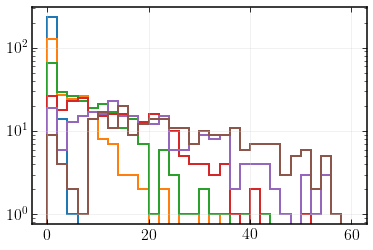

In [25]:
for k, v in results[2.0][0]['tss'].items():
    plt.hist(v, label='ninj {}'.format(k), histtype='step', lw=2., bins=np.linspace(0., 60., 31))
    
plt.yscale('log')
plt.show()

In [4]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'

data_fs = sorted(glob(greco_base + 'IC86_20*data_with_angErr.npy'))
exp = [np.load(data) for data in data_fs]
exp = np.hstack(exp)
mc = np.load(greco_base + 'IC86_2012.numu_with_angErr.npy')
grls = sorted(glob(greco_base + 'GRL/IC86_20*data.npy'))
grl = [np.load(g) for g in grls]
grl = np.hstack(grl)

greco = cy.selections.CustomDataSpecs.CustomDataSpec(exp, mc, np.sum(grl['livetime']), 
                                                     np.linspace(-1., 1., 31),
                                                     np.linspace(0., 4., 31), 
                                                     grl=grl, key='GRECOv2.2', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/greco_ana')
greco_ana = cy.get_analysis(cy.selections.repo, greco, dir=ana_dir)

Setting up Analysis for:
GRECOv2.2
Setting up GRECOv2.2...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [5]:
tab = Table.read('/home/apizzuto/Nova/source_list/appendix.tex')
df = tab.to_pandas()
coords = SkyCoord(frame="galactic", l=df['$l$']*u.degree, b=df['$b$']*u.degree)
equatorial = coords.icrs
df['ra'] = equatorial.ra.deg
df['dec'] = equatorial.dec.deg
df['gamma'] = [~np.char.startswith(fl, '$<$') for fl in df['Flux']] 
df = df.replace(['-'], np.nan)
df[u'$t_2$'] = df[u'$t_2$'].astype(float)

In [6]:
max_time_window = 5.
#df = df[~df['gamma']]
df['$t_2$'][np.isnan(df['$t_2$'])] = max_time_window
df['mjd'] = np.array([Time(pt, '%Y-%m-%d').mjd for pt in df['Peak Time']])
during_greco = (df['mjd'] > greco_ana.mjd_min) & (df['mjd'] + df['$t_2$'] < greco_ana.mjd_max)
df = df[during_greco]

/home/apizzuto/.venvs/py3_realtime/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
ras = df['ra']
decs = df['dec']
delta_t = df['$t_2$']
delta_t = np.minimum(delta_t, np.ones_like(delta_t)*max_time_window)

conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
       }

src = cy.utils.Sources(ra=np.radians(ras), 
                       dec=np.radians(decs), 
                       mjd=df['mjd'], 
                       sigma_t=np.zeros_like(delta_t), 
                       t_100=delta_t)

cy.CONF['src'] = src
cy.CONF['mp_cpus'] = 10

tr = cy.get_trial_runner(conf, ana=greco_ana, src=src)
n_trials = 500
bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 500 background trials using 10 cores:
        500/500 trials complete.   


## Differential sensitivity

In [13]:
reload(plotting)

<module 'plotting' from '/home/apizzuto/Nova/scripts/plotting.py'>

In [ ]:
stack_plots = plotting.StackingPlots(86400., seed=2, min_log_e=0.0)
stack_plots.get_all_sens()

cat = plotting.GammaCatalog(verbose = True)
cat.compare_photon_to_nus(delta_t = 1e5, omit_title=True)

ens = np.logspace(-1., 3., 500)
gam_cols = {2.0: 'C0', 2.5: 'C1', 3.0: 'C2'}

for gamma in [2.0, 2.5, 3.0]:
    sens = stack_plots.sensitivity[gamma]['E2dNdE']
    central_90_energies = cat.central_90[gamma]
        
    nu_sens_spec = np.power(ens, -gamma)*sens*1e3*(1e-3)**(2.-gamma)
    en_msk = (ens > central_90_energies[0]) & (ens < central_90_energies[1])
    plt.plot(ens[en_msk], nu_sens_spec[en_msk]*ens[en_msk]**2,
           color=gam_cols[gamma], lw = 3.0, zorder=5*(5.-gamma), ls='-.')

In [25]:
cat.central_90

{2.0: (23.26, 4430.12), 2.5: (8.69, 1594.0), 3.0: (4.76, 419.32)}

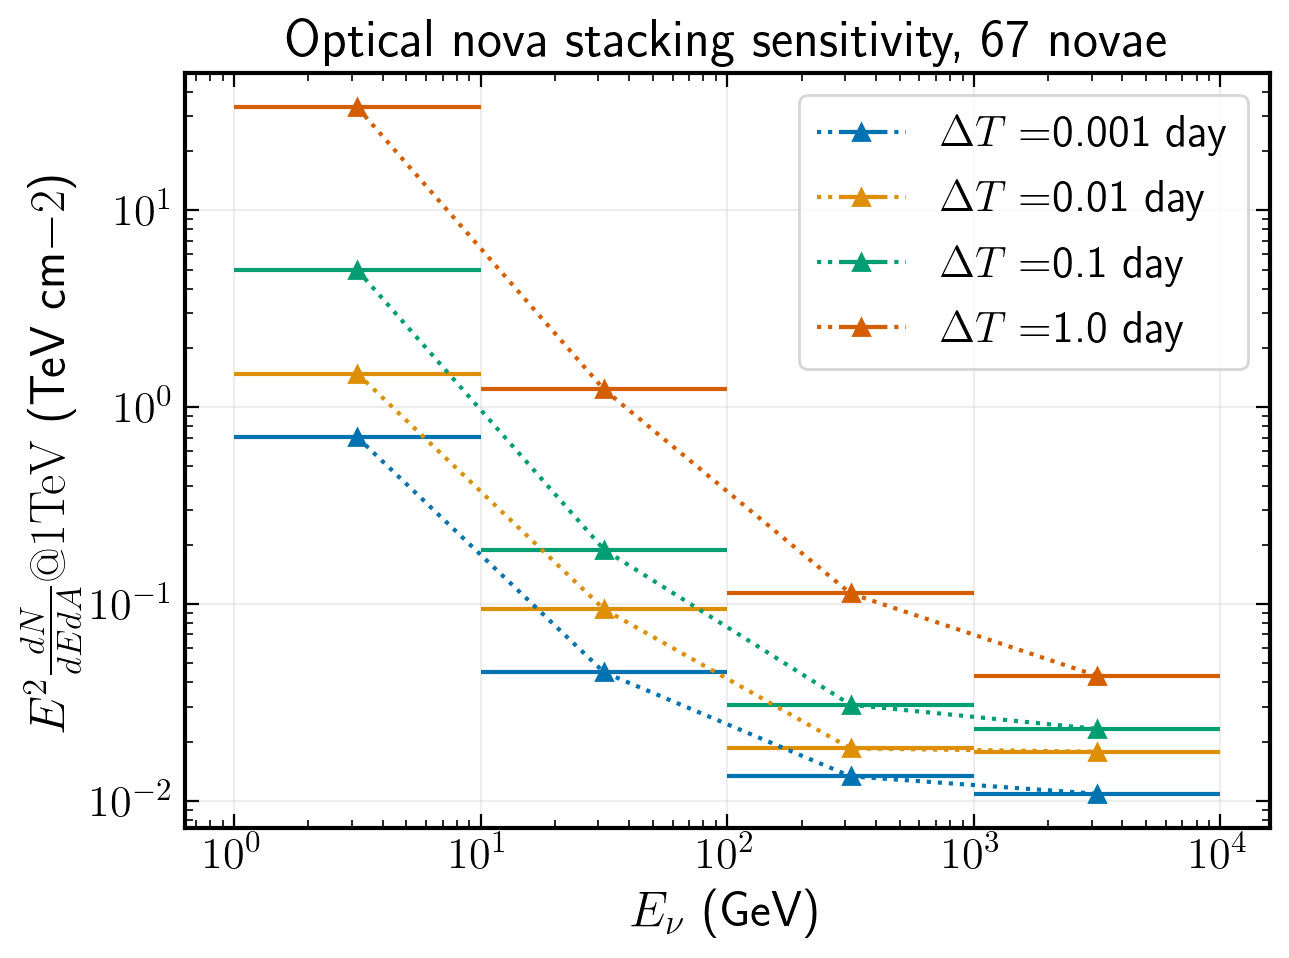

In [27]:
fig, ax = plt.subplots(dpi=200, figsize=(7,5))

for i, t in enumerate(np.logspace(0., 3., 4)*86.4):
    stack_plots = plotting.StackingPlots(t, seed=2, min_log_e=0.0)
    stack_plots.plot_differential_sens(ax=ax, color = palette[i], 
                                       label=r'$\Delta T = $' + f"{t/86400.} day")
    plt.legend()
    plt.title("Optical nova stacking sensitivity, 67 novae")

Text(0.5, 1.0, 'Optical nova stacking, (67 novae, $\\Delta T = 1$ day)')

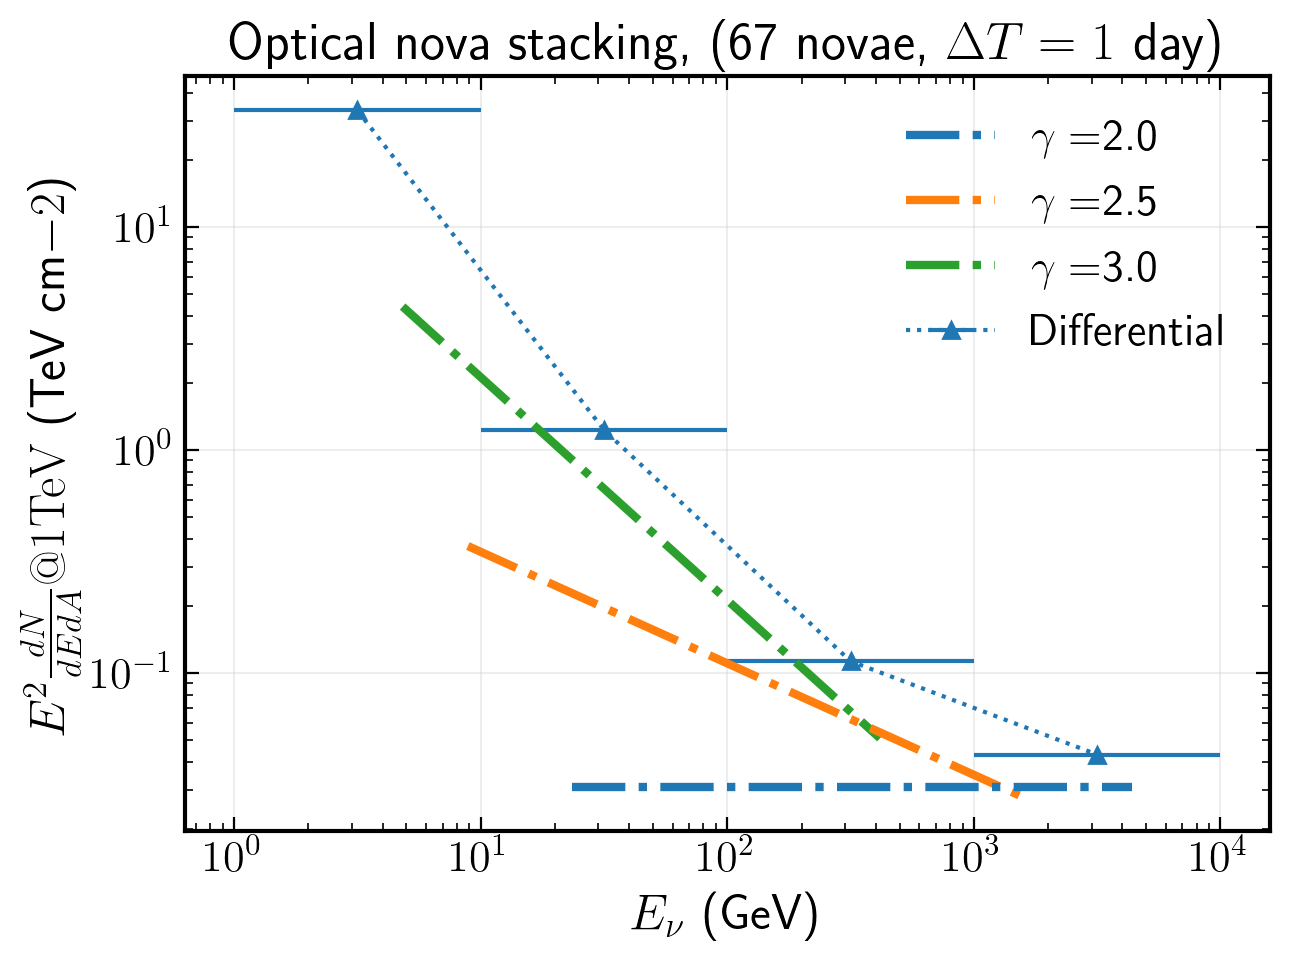

In [30]:
fig, ax = plt.subplots(dpi=200, figsize=(7,5))

stack_plots = plotting.StackingPlots(86400., seed=2, min_log_e=0.0)
stack_plots.get_all_sens()

cat = plotting.GammaCatalog(verbose = True)
#cat.compare_photon_to_nus(delta_t = 1e5, omit_title=True, fig=fig, ax=ax)

ens = np.logspace(-1., 5., 500)
gam_cols = {2.0: 'C0', 2.5: 'C1', 3.0: 'C2'}

for gamma in [2.0, 2.5, 3.0]:
    sens = stack_plots.sensitivity[gamma]['E2dNdE']
    central_90_energies = cat.central_90[gamma]
        
    nu_sens_spec = np.power(ens, -gamma)*sens*1e3*(1e-3)**(2.-gamma) / 1e3 # Convert to TeV cm^-2
    en_msk = (ens > central_90_energies[0]) & (ens < central_90_energies[1])
    plt.plot(ens[en_msk], nu_sens_spec[en_msk]*ens[en_msk]**2,
           color=gam_cols[gamma], lw = 3.0, zorder=5*(5.-gamma), ls='-.',
            label=r'$\gamma = $' + f"{gamma}")

stack_plots.plot_differential_sens(ax=ax, label=r'Differential')

plt.legend(frameon=False)
plt.title("Optical nova stacking, (67 novae, $\Delta T = 1$ day)")

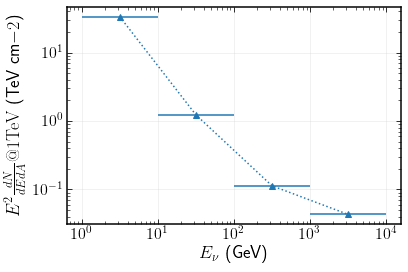

In [17]:
stack_plots.plot_differential_sens()

In [43]:
for en in [1., 10., 100., 1000.]:
    print(stack_plots.diff_sens[f'sensitivity_{en:.1f}_{en*10.:.1f}']['n_sig'])

3.4654520471569286
3.7902103360568318
2.091458192390185
2.695651414253487
